# **Kaggle HW5: Piyush Acharya**

**Remember to write your team name above, which MUST match your team name on Kaggle!!** Assignments without a team name will receive a 0/40 on the "accuracy on test data" component of this assignment's grade.

### **Load the Data**

In [219]:
# This cell is necessary only if you are running on Google Colab. It downloads the files to your
# Colab instance so you don't have to upload them here.

import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_train.csv',
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_test.csv',
          'edx_test.csv')

### **Sample Code: Random Classifier**

**NOTE**: This classifier **DOES NOT** count as one of the 2 required for this assignment! It is merely here to illstrate how to submit your predictions.

See the Kaggle assignment (Data tab) for a description of each column in the dataset. You are creating a classifier to predict whether or not a student will get certified, stored in the `"certified"` column.

In [220]:
import pandas as pd
from sklearn.dummy import DummyClassifier

target = "certified" # target column

# This classifier returns labels sampled uniformly at random
df_train = pd.read_csv('edx_train.csv')
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(df_train.drop(target, axis=1), df_train[target])

DummyClassifier(strategy='uniform')

The code below generates predictions on the test set, and outputs the predictions into a CSV file.

In [221]:
# Generate predictions on the test set
df_test = pd.read_csv('edx_test.csv')
predictions = dummy_model.predict(df_test)

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission.csv', index=False)

# See below for instructions on how to upload submission.csv to Kaggle,
# in order to evaluate your model and get points.

### **[5 Pts] Model Comparison**

**Instructions**: Run at least 2 different classification models. The classification models we have learned in class are: [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), and [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [Neural Networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html). For each model, try at least 2 different hyperparameter settings.

Then, make one or more visualizations that let you compare the models you trained. Sample visualizations you can make include confusion matrices, or graphs of train and validation accuracy/error. See past section and homework code for how to make these visualizations.

C:\Users\achar\AppData\Local\Temp\ipykernel_21164\1026713973.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col]).astype('int64') // 10**9
C:\Users\achar\AppData\Local\Temp\ipykernel_21164\1026713973.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col]).astype('int64') // 10**9
C:\Users\achar\AppData\Local\Temp\ipykernel_21164\1026713973.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col]).astype('int64') // 10**9
C:\Users\achar\AppData\Local\Temp\ipykernel_21164\1026713973.

Epoch [1/10], Train Loss: 0.2560, Val Loss: 0.1573, Train Accuracy: 0.9214, Val Accuracy: 0.9406
Epoch [2/10], Train Loss: 0.1236, Val Loss: 0.1402, Train Accuracy: 0.9532, Val Accuracy: 0.9481
Epoch [3/10], Train Loss: 0.1177, Val Loss: 0.1349, Train Accuracy: 0.9565, Val Accuracy: 0.9538
Epoch [4/10], Train Loss: 0.1148, Val Loss: 0.1325, Train Accuracy: 0.9596, Val Accuracy: 0.9555
Epoch [5/10], Train Loss: 0.1089, Val Loss: 0.1285, Train Accuracy: 0.9612, Val Accuracy: 0.9566
Epoch [6/10], Train Loss: 0.1069, Val Loss: 0.1235, Train Accuracy: 0.9627, Val Accuracy: 0.9583
Epoch [7/10], Train Loss: 0.1036, Val Loss: 0.1229, Train Accuracy: 0.9626, Val Accuracy: 0.9618
Epoch [8/10], Train Loss: 0.1037, Val Loss: 0.1195, Train Accuracy: 0.9635, Val Accuracy: 0.9600
Epoch [9/10], Train Loss: 0.1021, Val Loss: 0.1195, Train Accuracy: 0.9633, Val Accuracy: 0.9572
Epoch [10/10], Train Loss: 0.0997, Val Loss: 0.1187, Train Accuracy: 0.9656, Val Accuracy: 0.9618


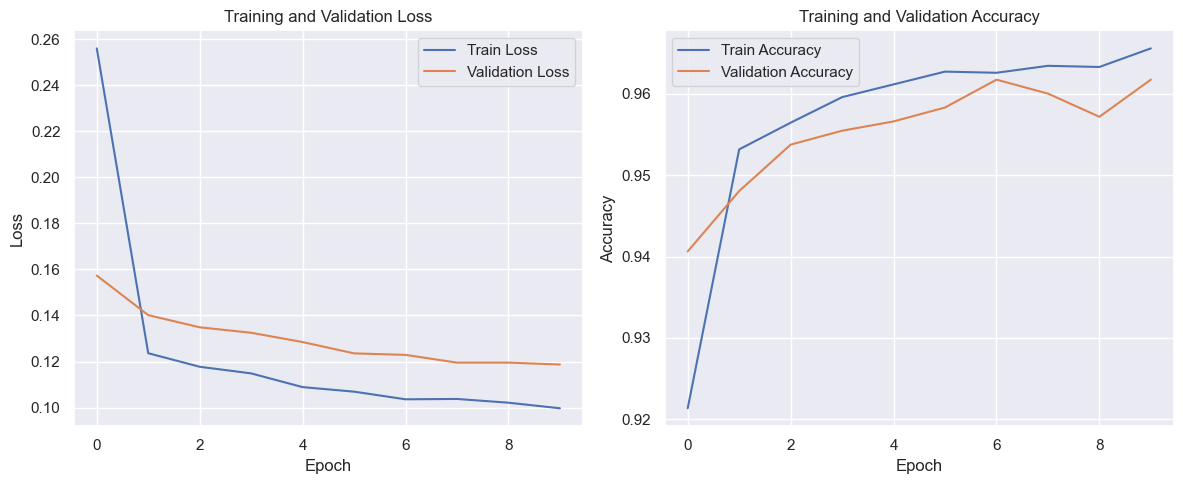

In [222]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and preprocess data
def preprocess(df):
    # Convert categorical columns to numeric
    cat_cols = ["course_id", "final_cc_cname_DI", "LoE_DI", "gender"]
    for col in cat_cols:
        df[col] = pd.Categorical(df[col]).codes
    
    # Convert date columns to timestamps
    date_cols = ["start_time_DI", "last_event_DI"]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col]).astype('int64') // 10**9
    
    # Fill NaN values
    df = df.fillna(-1)
    
    return df

df_train = pd.read_csv('edx_train.csv')
df_test = pd.read_csv('edx_test.csv')

df_train = preprocess(df_train)
df_test = preprocess(df_test)

# Split features and target
X = df_train.drop(["userid_DI", "certified"], axis=1)
y = df_train["certified"]

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values)

# Create dataset and dataloader
class EdXDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EdXDataset(X_train_tensor, y_train_tensor)
val_dataset = EdXDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = Net(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item()
            
            predicted = (outputs.squeeze() > 0.5).float()
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plot training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Make predictions on test set
X_test = df_test.drop(["userid_DI"], axis=1)
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test_scaled)

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.to(device))
    predictions = (test_outputs.squeeze() > 0.5).float().cpu().numpy()

# Create submission file
submission = pd.DataFrame({
    'userid_DI': df_test['userid_DI'],
    'certified': predictions.astype(int)
})
submission.to_csv('submission.csv', index=False)


**Remember to submit your submissions CSV FILE on Kaggle!** 40 pts come from your accuracy on the private test data.

Attend section on Thurs 5/11 for a demo of how to uppload submissions to Kaggle. We also have screenshots below (ingore summer and homework number in pictures)

Step 1: See the list of files on Colab

![See Colab Files](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/1_colab_see_files.jpg)

Step 2: Download `submission.csv`

![Download Colab File](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/2_colab_download_file.jpg)

Step 3: Join the Kaggle competition.

![Join the Kaggle Competition](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/3_kaggle_join_competition.jpg)

Step 4: Enusre your team name in Kaggle matches the one at the top of this notebook!

![Check Team Name](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/4_kaggle_team_name.jpg)

Step 5: Upload `submission.csv` to Kaggle

![Upload submission.csv](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/6_kaggle_upload_submission.jpg)



### **Discussion**



#### **[7 Pts] Training the Models**

**Instructions**: Discuss what models you tried, and what you did to improve your initial predictions. Discuss what hyperparameters you tried, and which hyperparameters seemed important for your final model. Finally, discuss what you are inferring from the above visualiation(s).

#### **[3 Pts] Feature Selection**

**Instructions**: Discuss what features you used and whether you did some transformations on them. What features seemed important for your final model?

#### **[5 Pts] Ethical Implications**

**Instructions**: Consider and discuss the ethical implications of using the model you trained. Imagine you were hired to work as a data scientist for an online education platform (exciting, right?). They want to use your model to predict which students they should tailor their course material towards so they can maximize their profits. Their idea is to use the model to help predict which student groups (i.e. from specific countries or certain educational backgrounds) would make them the most money by getting the most participants to complete their paid certificate program. Are there any ethical considerations we should think about before acting on that plan?